In [1]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist
from numpy.linalg import LinAlgError
import re

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf  # Import Ledoit-Wolf estimator
from sklearn.covariance import shrunk_covariance, EmpiricalCovariance


Read in data

In [2]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [3]:
# Format the data to work with existing code
labels = node_labels

# just look at a specified timepoint
dense_adj = As[1]
print(np.mean(dense_adj))

0.06194932040161191


## Function definitions

In [4]:
def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below


def plot_ellipse(ax, mean, cov, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)


# TO AVOID SINGULAR MATRIX ERROR
def points_within_ellipse(points, mean, cov, regularization=1e-32, threshold=3):
    try:
        # Attempt to calculate the inverse of the covariance matrix
        inv_cov = np.linalg.inv(cov)
    except LinAlgError:
        # If the matrix is singular, regularize and retry
        cov += np.eye(cov.shape[0]) * regularization
        inv_cov = np.linalg.inv(cov)
    
    # Calculate the Mahalanobis distance from the mean
    diff = points - mean
    mahalanobis_distances = np.sum(diff @ inv_cov * diff, axis=1)/cov.shape[0]
    
    # Points within the ellipse have a Mahalanobis distance <= threshold
    return mahalanobis_distances <= threshold


In [5]:
## Test:
distlist=[]
for td in range(1,100):
    tpos=np.random.normal(0,1,[1000,td])
    tdist=np.sum(tpos * tpos, axis=1)
    distlist.append(np.mean(tdist))
#distlist # scales linearly with d

In [6]:
def create_single_kNN_prone_bootstrap(A, d, Q=1000, n_neighbors=5):
    n = A.shape[0]
    A_obs = A.copy()

    # Embed the graphs -------------------------------

    yhat = unfolded_prone(A, d=d, flat=True)

    # run a k-NN on the embedding yhat
    # Here we use Minkowski distance, with p=2 (these are the defaults),
    # which corresponds to Euclidean distance
    from sklearn.neighbors import NearestNeighbors

    nbrs = NearestNeighbors(
        n_neighbors=n_neighbors, algorithm="ball_tree", metric="minkowski", p=2
    ).fit(yhat)
    distances, indices = nbrs.kneighbors(yhat)

    # Estimate the P matrix -------------------------------
    P_est = P_est_from_A_obs(n, A_obs, n_neighbors=n_neighbors, indices=indices)

    # Bootstrap -----------------------------------------
    A_est = make_inhomogeneous_rg(P_est)

    # embed the observed and bootstrapped matrices together --------------------------------
    yhat_est = UASE([A_obs, A_est], d=d)

    # do a test between the obs and the bootstrap, get a p-value ---------------------------------
    p_val = test_temporal_displacement_two_times(yhat_est, n, n_sim=Q)


    return p_val, A_est


In [7]:
def get_score(A,d,B=100,Q=1000,seed=None,f=create_single_kNN_bootstrap,  *args, **kwargs):
    if(seed):
        random.seed(seed)
        np.random.seed(100)
    p_vals = []
    A_boots_list = []

    for b in tqdm(range(B)):
        p_val, A_boots = f(dense_adj, d=d, Q=1000, *args, **kwargs)
        p_vals.append(p_val)
        A_boots_list.append(A_boots)

    # Provided code
    p_hat_list = p_vals
    roc = []
    alphas = []

    for alpha in np.linspace(0, 1, 100):
        alphas.append(alpha)
        num_below_alpha = sum(p_hat_list < alpha)
        roc_point = num_below_alpha / len(p_hat_list)
        roc.append(roc_point)

    # Get the power at the 5% significance level
    power_significance = 0.05
    power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
    power = roc[power_idx]
    
    # Calculate the area between ROC and y=x line
    x = np.linspace(0, 1, 100)
    roc_interpolated = np.interp(x, alphas, roc)

    # Compute areas
    area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
    total_area = area_above + area_below

    return total_area, power, alphas, roc
    

## Begin analysis: Computing performance of embeddings for bootstrapping

In [8]:
k = 5
B = 500
d = 10

[25, 50, 100, 150, 200, 250, 300, 400, 500]

In [67]:
Blist=[25,50,100,150,200,250,300,400,500]
# Define the list of perplexity values
perp_values = list(range(5, 240, 10))
tfriendslist=[]

for tB in tqdm(Blist):
    tA_boots_list_knn = []
    for b in range(tB):
        p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        tA_boots_list_knn.append(A_boots)
    tA_knn_list = [dense_adj] + tA_boots_list_knn
    tyhat_knn = UASE(tA_knn_list, d=d, sparse_matrix=False)

    yadf = tyhat_knn
    yadf = pd.DataFrame(tyhat_knn)
    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(tyhat_knn.shape[1])] 
    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, tB + 1)
    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(tB+1), len(labels))
    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(tB+1)
    
    tfriends=get_friends(yadf,threshold=3)
    tfriendslist.append(tfriends)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:16<00:00,  8.48s/it]


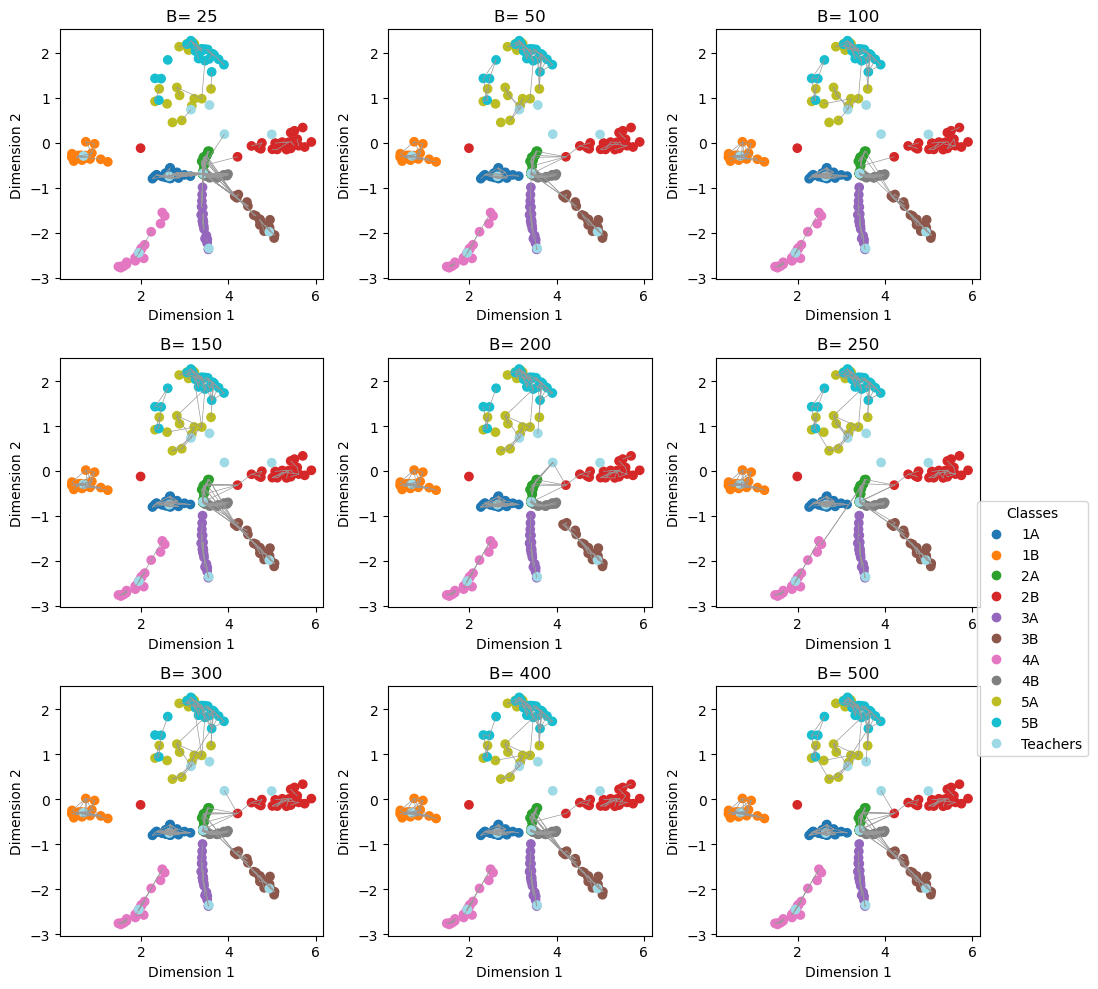

In [73]:
# Define the list of perplexity values

tsne = TSNE(n_components=2, perplexity=125, random_state=0)
# tSNE the true adjacency matrix
A_tsne = tsne.fit_transform(dense_adj)

    # Convert to DataFrame
A_tsne_df = pd.DataFrame(A_tsne)
A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
A_tsne_df["tau"] = np.tile(node_labels, 1)


# Set up the 2m2subplot grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
# Iterate over the embeddings and subplot indices
for idx in np.array(range(len(Blist))):
    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension_1"], A_tsne_df["Dimension_2"], c=A_tsne_df["tau"], cmap='tab20',zorder=0)
    ax.set_title(f"B= {Blist[idx]}")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the "friends" matrix, U
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if tfriendslist[idx][i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension_1"].iloc[i], A_tsne_df["Dimension_1"].iloc[j]], 
                        [A_tsne_df["Dimension_2"].iloc[i], A_tsne_df["Dimension_2"].iloc[j]], 
                        '-', lw=0.5, color='#999999FF',zorder=1)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.savefig("figs/school_Bcomparison.png", facecolor='white')

# Show the combined plot
plt.show()

In [9]:
XXTscorelist=[]
XXTpowerlist=[]
XXTalphaslist=[]
XXTroclist=[]
for td in range(2,d+1):
    tscore,tpower,talphas,troc = get_score(dense_adj,d=td,B=B,f=create_single_parametric_bootstrap_cropPto0_1range)
    XXTscorelist.append(tscore)
    XXTpowerlist.append(tpower)
    XXTalphaslist.append(talphas)
    XXTroclist.append(troc)

  0%|                                                                                                                                                                               | 0/500 [00:00<?, ?it/s]/Users/madjl/code/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:109: UserWarning: P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.
  warnings.warn("P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.")
  0%|▎                                                                                                                                                                      | 1/500 [00:01<09:39,  1.16s/it]/Users/madjl/code/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:109: UserWarning: P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.
  warnings.warn("P_hat contains values outside of [0,1]. The values ou

In [10]:
XXTscore,XXTpower,XXTalphas,XXTroc = get_score(dense_adj,d,B=B,f=create_single_parametric_bootstrap_cropPto0_1range)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 38.23it/s]


In [11]:
klist=range(2,13)
kscorelist=[]
kpowerlist=[]
kalphaslist=[]
kroclist=[]
nrep=1
for run in range(0,nrep):
    np.random.seed(run+1)
    kkscorelist=[]
    for tk in klist:
    #    print(f"k={tk}")
        kscore,kpower,kalphas,kroc = get_score(dense_adj,d,B=B,f=create_single_kNN_bootstrap,n_neighbors=tk)
        kkscorelist.append(kscore)
    kpowerlist.append(kpower)
    kalphaslist.append(kalphas)
    kroclist.append(kroc)
    kscorelist.append(kkscorelist)
    
kscorearray = np.array(kscorelist)
kscoremean = np.mean(kscorearray, axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 37.69it/s]


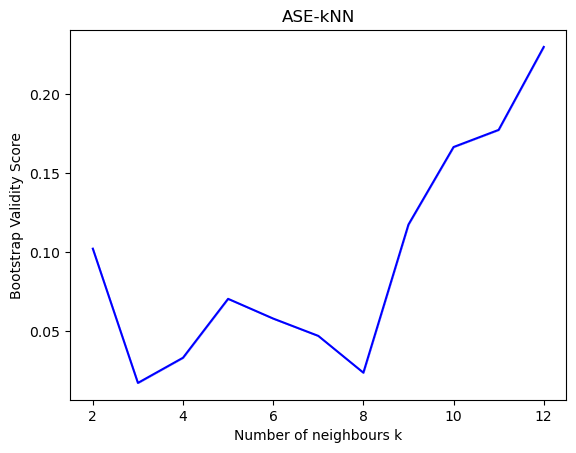

In [12]:

# Step 1: Set the quantiles for 95% confidence interval
lower_quantile = 0.1
upper_quantile = 0.9

# Step 2: Compute the quantiles for each column
klower_bounds = np.quantile(kscorearray, lower_quantile, axis=0)
kupper_bounds = np.quantile(kscorearray, upper_quantile, axis=0)

# Step 2: Plot the mean score values
plt.plot(klist, kscoremean, c="blue",label="kNN")
plt.xlabel("Number of neighbours k")
plt.ylabel("Bootstrap Validity Score")
plt.title("ASE-kNN")
#plt.plot([10,10],[2300,2600])

# Step 3: Fill the area between the lower and upper bounds to represent confidence intervals
plt.fill_between(klist,klower_bounds, kupper_bounds, color='b', alpha=0.2)
plt.savefig("figs/Supp-ASEknn-ValidityVsk.png", facecolor='white')

plt.show()

In [13]:
print(XXTscore)
print(XXTscorelist)
#print(kscorelist)

0.1555143707090447
[0.47538822569125583, 0.47721701867156396, 0.4231845730027546, 0.43258055300479537, 0.4326199367411488, 0.4372310988674623, 0.3864658708295073, 0.1739533078635211, 0.15729271904845826]


In [14]:
kdscorelist=[]
kdpowerlist=[]
kdalphaslist=[]
kdroclist=[]
for td in range(2,d+1):
    tscore,tpower,talphas,troc = get_score(dense_adj,d=td,B=B,f=create_single_kNN_bootstrap)
    kdscorelist.append(tscore)
    kdpowerlist.append(tpower)
    kdalphaslist.append(talphas)
    kdroclist.append(troc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.20it/s]


In [15]:
pscorelist=[]
ppowerlist=[]
palphaslist=[]
proclist=[]
for td in range(2,d+1):
    tscore,tpower,talphas,troc = get_score(dense_adj,d=td,B=B,f=create_single_kNN_prone_bootstrap)
    pscorelist.append(tscore)
    ppowerlist.append(tpower)
    palphaslist.append(talphas)
    proclist.append(troc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 41.94it/s]


In [16]:
print(XXTscorelist)
print(kdscorelist)
print(pscorelist)

[0.47538822569125583, 0.47721701867156396, 0.4231845730027546, 0.43258055300479537, 0.4326199367411488, 0.4372310988674623, 0.3864658708295073, 0.1739533078635211, 0.15729271904845826]
[0.011582119789879169, 0.02516601815522849, 0.024153653152275772, 0.0539489847974697, 0.02626742715553382, 0.05857863375103966, 0.017930891405638912, 0.09227221712070201, 0.069554535251505]
[0.23840024415154512, 0.0307225721879839, 0.1793739288954573, 0.0362111256427143, 0.020727816889433034, 0.03453205017216342, 0.03233546802141843, 0.1258170230376036, 0.23392062034486288]


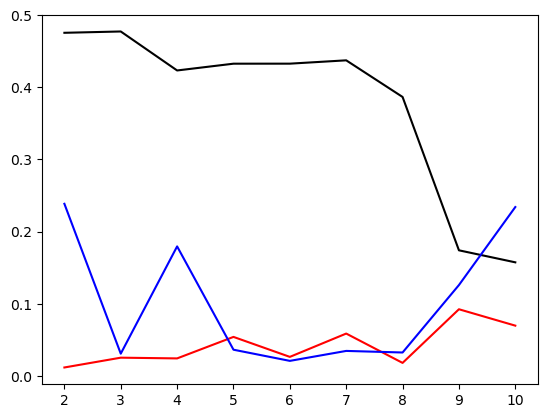

In [17]:
plt.plot(range(2,d+1), XXTscorelist, c="black",label="XXT")
plt.plot(range(2,d+1), kdscorelist, c="red",label="kNN")
plt.plot(range(2,d+1), pscorelist, c="blue",label="PRoNE")


In [18]:
k
#range(2,d)[7]

5

In [19]:
XXTscore,XXTpower,XXTalphas,XXTroc = get_score(dense_adj,d,B=B,f=create_single_parametric_bootstrap_cropPto0_1range)
kscore,kpower,kalphas,kroc = get_score(dense_adj,d,B=B,f=create_single_kNN_bootstrap,n_neighbors=k)
pscore6,ppower6,palphas6,proc6 = get_score(dense_adj,6,B=B,f=create_single_kNN_prone_bootstrap,n_neighbors=k)
pscore,ppower,palphas,proc = get_score(dense_adj,d,B=B,f=create_single_kNN_prone_bootstrap,n_neighbors=k)

  0%|                                                                                                                                                                               | 0/500 [00:00<?, ?it/s]/Users/madjl/code/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:109: UserWarning: P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.
  warnings.warn("P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.")
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.07it/s]


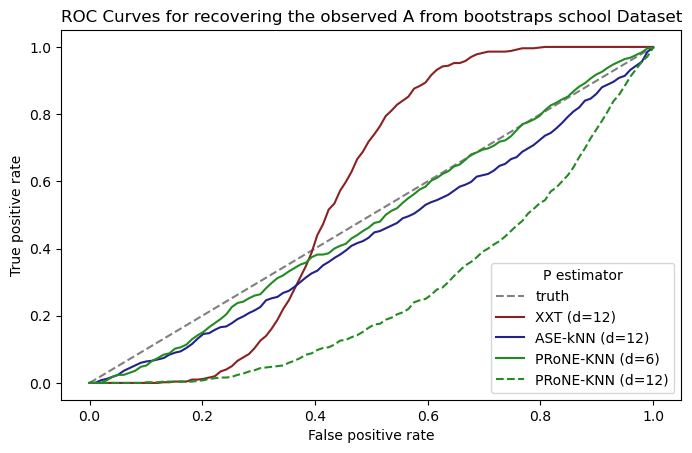

In [20]:
plt.figure().set_figwidth(8)
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey",label="truth")
plt.plot(XXTalphas, XXTroc, color='#8B2222',label="ASE (d=10)")
plt.plot(kalphas, kroc, color='#22228B',label="ASE-kNN (d=10)")
plt.plot(palphas, proc6, color='#228B22',label="ProNE-kNN (d=6)")
plt.plot(palphas, proc, color='#228B22',linestyle="--",label="ProNE-kNN (d=10)")

# Set title and aspect ratio
plt.title(f"ROC Curves for recovering the observed A from bootstraps school Dataset")
#plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right',title='P estimator')
# Adding axis labels
plt.xlabel('False positive rate')  # Add label to the x-axis
plt.ylabel('True positive rate')

plt.savefig("Figs/school_example_roccurves.png", facecolor='white')

plt.show()

## Examining the different estimates of P

In [21]:
yhatprone = unfolded_prone(dense_adj, d=6, flat=True)
yhatuase = UASE([dense_adj], d=d, flat=True)
n_neighbors=5
# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults),
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors
nbrsprone = NearestNeighbors(
    n_neighbors=n_neighbors, algorithm="ball_tree", metric="minkowski", p=2
).fit(yhatprone)
nbrsuase = NearestNeighbors(
    n_neighbors=n_neighbors, algorithm="ball_tree", metric="minkowski", p=2
).fit(yhatuase)

pronedistances, proneindices = nbrsprone.kneighbors(yhatprone)
uasedistances, uaseindices = nbrsuase.kneighbors(yhatuase)

# Estimate the P matrix -------------------------------
P_estprone = P_est_from_A_obs(n, dense_adj, n_neighbors=n_neighbors, indices=proneindices)
P_estuase = P_est_from_A_obs(n, dense_adj, n_neighbors=n_neighbors, indices=uaseindices)

# Bootstrap -----------------------------------------
#A_est = make_inhomogeneous_rg(P_est)

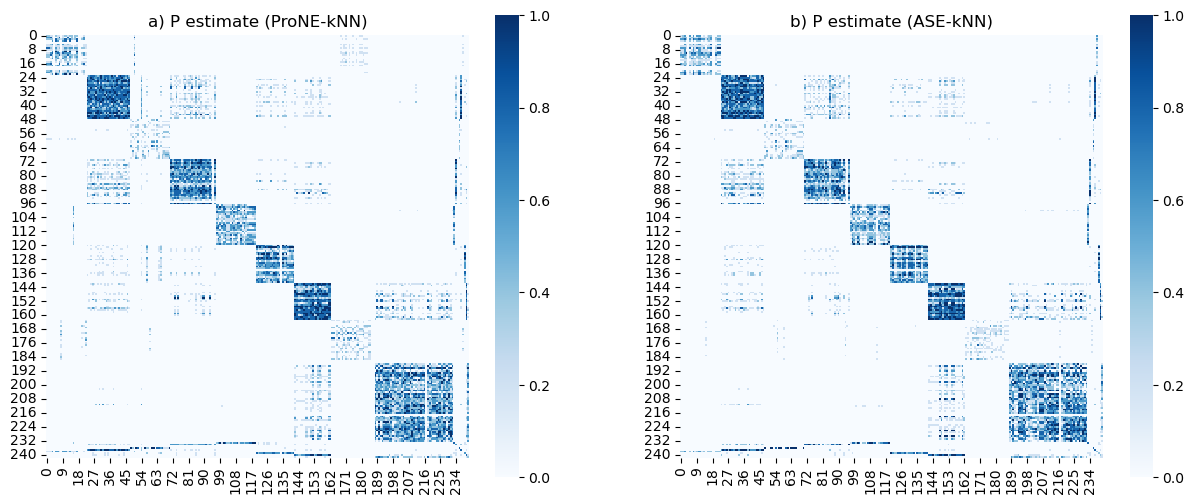

In [46]:
#print([np.mean(P_estprone),np.mean(P_estuase),np.var(P_estprone),np.var(P_estuase)])
#np.corrcoef(P_estprone.flatten(),P_estuase.flatten())
#fig, (ax0,ax1, ax2) = plt.subplots(3, 1, figsize=(6, 15))

#sns.heatmap(1-dense_adj, square=True,ax=ax0)
#sns.heatmap(1-P_estprone, square=True,ax=ax1)
#sns.heatmap(1-P_estuase, square=True,ax=ax2)
#plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.color_palette("rocket", as_cmap=True)
sns.heatmap(P_estprone, square=True,ax=ax1,cmap='Blues')
sns.heatmap(P_estuase, square=True,ax=ax2,cmap='Blues')
ax1.set_title("a) P estimate (ProNE-kNN)")
ax2.set_title("b) P estimate (ASE-kNN)")
plt.savefig("figs/FigPhatProneVsKnn.png", facecolor='w')
plt.show()

## Get the bootstraps from our "Favoured" method

In [23]:
A_boots_list_prone = []
A_boots_list_knn = []
d_prone=6
for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_prone_bootstrap(dense_adj, d=d_prone, Q=1000, n_neighbors=k)
    A_boots_list_prone.append(A_boots)
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    A_boots_list_knn.append(A_boots)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:20<00:00, 24.89it/s]


In [24]:
A_prone_list = [dense_adj] + A_boots_list_prone
A_knn_list = [dense_adj] + A_boots_list_knn

yhat_prone = UASE(A_prone_list, d=d, sparse_matrix=False)
yhat_knn = UASE(A_knn_list, d=d, sparse_matrix=False)

In [25]:
yadflist=[]
for yhat in [yhat_prone,yhat_knn]:
    yadf = pd.DataFrame(yhat)
    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 
    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, B + 1)
    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(B+1), len(labels))
    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)
    yadflist.append(yadf)

## Compute which nodes could be mistaken for which other nodes

In [34]:
def get_friends(yadf,threshold=3):
    """"create an adjacency matrix of nodes that overlap in uncertainty"""
    n=np.int64(yadf.shape[0]/(1+np.max(yadf["Matrix"])))
    in_cov_friends = np.zeros((n,n))
    
    for i in range(n):
        # Filter data for node number and select the relevant dimensions
        node_number = i
        data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

        # Calculate the mean and covariance considering all d dimensions
        mean_d_dim = np.mean(data_d_dim, axis=0)
        cov_d_dim = np.cov(data_d_dim, rowvar=False)

        # Use the point corresponding to the specific node_number in matrix 0 as the center
        point = data_d_dim[0]
        obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

        # Filter points within the ellipse
        inside_ellipse = points_within_ellipse(obs_points, point, cov_d_dim, threshold=threshold)

        # Extract node numbers for points inside the ellipse
        node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

        # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
        in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
    # minimum means both must be 1
    # maximum means at least one must be 1
    in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
    return(in_cov_friends_symm)

in_cov_friends_symm_prone=get_friends(yadflist[0],threshold=3) # correction for dimensions differences
in_cov_friends_symm_knn=get_friends(yadflist[1],threshold=3)
#sns.heatmap(in_cov_friends_symm, square=True)
#print(np.mean(in_cov_friends_symm))

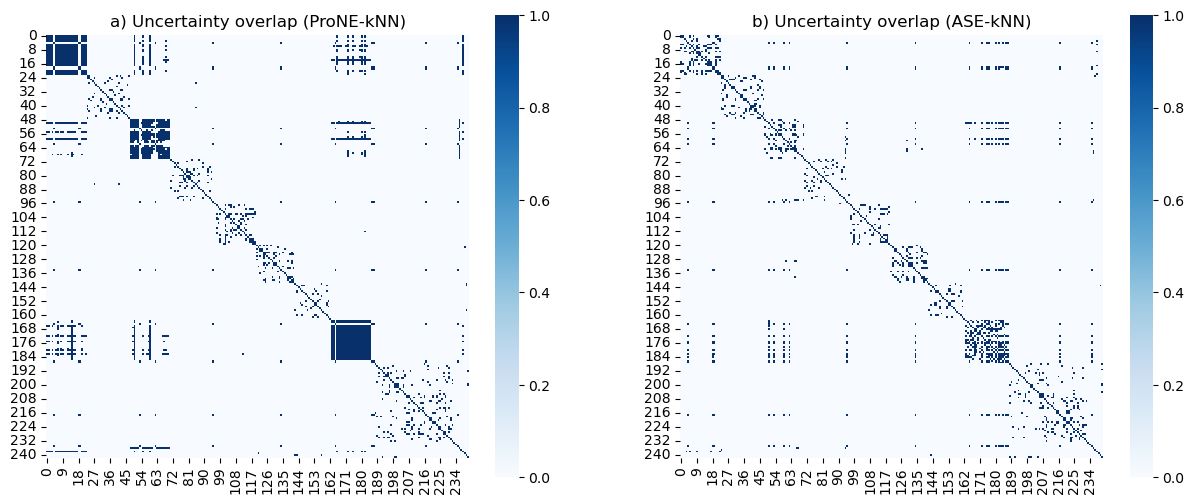

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.color_palette("rocket", as_cmap=True)
sns.heatmap(in_cov_friends_symm_prone, square=True,ax=ax1,cmap='Blues')
sns.heatmap(in_cov_friends_symm_knn, square=True,ax=ax2,cmap='Blues')
ax1.set_title("a) Uncertainty overlap (ProNE-kNN)")
ax2.set_title("b) Uncertainty overlap (ASE-kNN)")
plt.savefig("figs/FigFriendsProneVsKnn.png", facecolor='w')
plt.show()


## Scoring the results of Tsne with the 

In [36]:
def uncertainty_score(E,A):
    ## Takes an adjacency matrix A and an embedding E and averages the length of all edges of A in E
    n = A.shape[0]
    score = 0
    meandist = 0
    edgecount = 0
    for i in range(n):
        for j in range(n):
            edgecount += A[i,j]
            meandist += A[i,j] * np.sqrt((np.linalg.norm(E[i,:] - E[j,:])))
    meandist = meandist / edgecount
    for i in range(n):
        for j in range(n):
            score += A[i,j] * (np.sqrt((np.linalg.norm(E[i,:] - E[j,:]))) - meandist)**2 /edgecount
    return(np.sqrt(score))
    

In [37]:
# Define the list of perplexity values
perp_values = list(range(5, 240, 10))
score_values_prone = []
score_values_knn = []
tsne_list = []
n = dense_adj.shape[0]

# Iterate over the perplexity values and subplot indices
for perp_val in tqdm(perp_values):
    # Create the t-SNE embedding
    tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
    # tSNE the true adjacency matrix
    A_tsne = tsne.fit_transform(dense_adj)

    # Convert to DataFrame
    A_tsne_df = pd.DataFrame(A_tsne)
    A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
    A_tsne_df["tau"] = np.tile(node_labels, 1)

    # Standardize the data in the Dimension_1 and Dimension_2 columns - mean 0, sd 1
    scaler = StandardScaler()
    # Fit the scaler on the Dimension columns and transform them
    A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])
    
    tsne_list.append(A_tsne_df.iloc[:, 0:2].values)
 
    score=uncertainty_score(A_tsne_df.iloc[:, 0:2].values,in_cov_friends_symm_prone)
    score_values_prone.append(score)

    score=uncertainty_score(A_tsne_df.iloc[:, 0:2].values,in_cov_friends_symm_knn)
    score_values_knn.append(score)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:26<00:00,  1.10s/it]


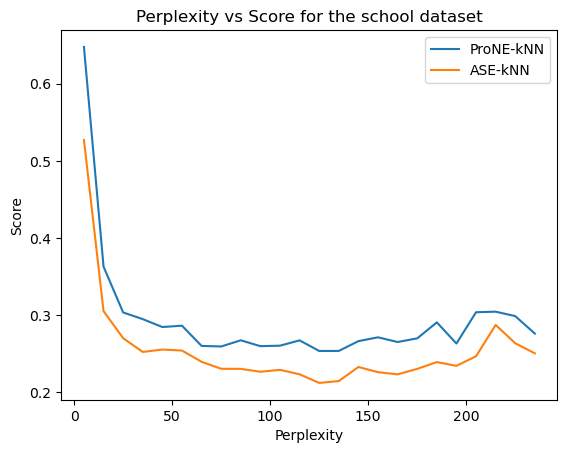

In [55]:
# plot perplexity vs score
plt.plot(perp_values, score_values_prone,label="ProNE-kNN")
plt.plot(perp_values, score_values_knn,label="ASE-kNN")
plt.xlabel("Perplexity")
plt.ylabel("Score")
plt.title("Perplexity vs Score for the school dataset")
plt.legend(loc="upper right")
plt.savefig("figs/Perplexity_vs_Score_schoolA1_B50.png", facecolor='w')
plt.show()

## Visualisation of two important perplexities

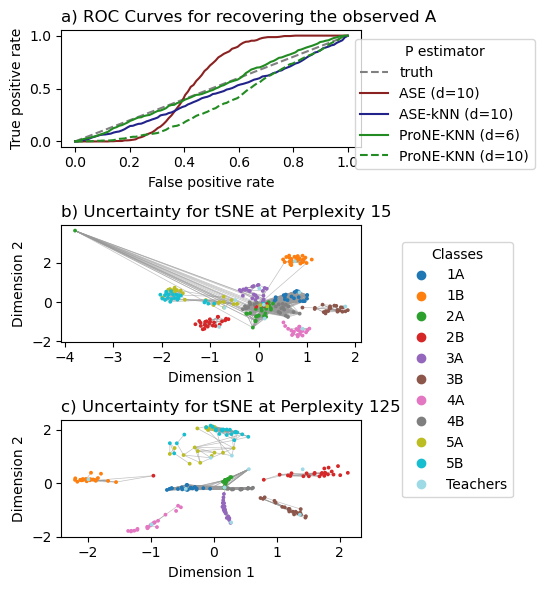

In [56]:
# Define the list of perplexity values
perps=[15,125]
perp_idx=[perp_values.index(x) for x in perps]
A_array2=[tsne_list[perp_idx[0]],tsne_list[perp_idx[1]]]

# Set up the subplot grid
fig, axs = plt.subplots(3, 1, figsize=(7, 6))
annot=["b) Uncertainty for tSNE at Perplexity 15",
       "c) Uncertainty for tSNE at Perplexity 125"]

# Iterate over the embeddings and subplot indices
ax = axs[0]
ax.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey",label="truth")
ax.plot(XXTalphas, XXTroc, color='#8B2222',label="ASE (d=10)")
ax.plot(kalphas, kroc, color='#22228B',label="ASE-kNN (d=10)")
ax.plot(palphaslist[4], proclist[4], color='#228B22',label="ProNE-KNN (d=6)")
ax.plot(palphaslist[7], proclist[7], color='#228B22',linestyle="--",label="ProNE-KNN (d=10)")

# Set title and aspect ratio
ax.set_title(f"a) ROC Curves for recovering the observed A",loc="left")
#plt.gca().set_aspect('equal', adjustable='box')
ax.legend(loc='lower right',title='P estimator', bbox_to_anchor=(1.6, -0.25))
# Adding axis labels
ax.set_xlabel('False positive rate')  # Add label to the x-axis
ax.set_ylabel('True positive rate')

for tidx, A_tsne_df in enumerate(A_array2):
    idx=tidx+1
    # Convert to DataFrame
    A_tsne_df = pd.DataFrame(A_tsne_df)
    A_tsne_df.columns = ["Dimension {}".format(i+1) for i in range(A_tsne_df.shape[1])]
    A_tsne_df["tau"] = np.tile(node_labels, 1)

    # Select the subplot
    ax = axs[idx % 3]
    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension 1"], A_tsne_df["Dimension 2"], 
                         s=3,c=node_labels,cmap='tab20',zorder=1)

    ax.set_title(f"{annot[tidx]}",loc="left")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the "friends" matrix, U
    # Draw lines between connected nodes based on the "friends" matrix, U
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if in_cov_friends_symm_prone[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension 1"].iloc[i], A_tsne_df["Dimension 1"].iloc[j]], 
                        [A_tsne_df["Dimension 2"].iloc[i], A_tsne_df["Dimension 2"].iloc[j]], 
                        '-', lw=0.5, color='#99999999',zorder=0)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(0.75, 0.6))

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.savefig("figs/FigSchoolEmbedding.png", facecolor='white')

# Show the combined plot
plt.show()

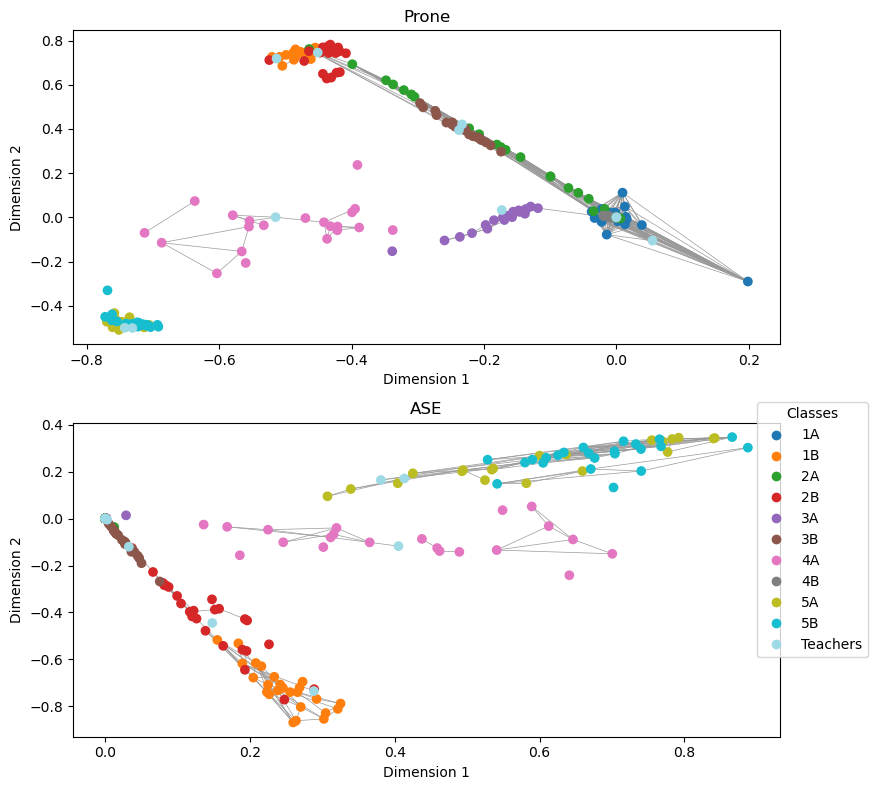

In [45]:
# Define the list of perplexity values
yhatprone = unfolded_prone(dense_adj, d=6, flat=True)
yhatuase = UASE([dense_adj], d=d, flat=True)

A_array2=[yhatprone[:,range(2)],
         yhatuase[:,range(2)]]
friends_array2=[in_cov_friends_symm_prone,in_cov_friends_symm_knn]

# Set up the subplot grid
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
perps=[15,40]
annot=["Prone","ASE"]
# Iterate over the embeddings and subplot indices
for idx, A_tsne_df in enumerate(A_array2):

    # Convert to DataFrame
    A_tsne_df = pd.DataFrame(A_tsne_df)
    A_tsne_df.columns = ["Dimension {}".format(i+1) for i in range(A_tsne_df.shape[1])]
    A_tsne_df["tau"] = np.tile(node_labels, 1)

    # Select the subplot
    ax = axs[idx % 2]
    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension 1"], A_tsne_df["Dimension 2"], c=node_labels,cmap='tab20',zorder=1)

    ax.set_title(f"{annot[idx]}")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    in_cov_friends_symm=friends_array2[idx]
    # Draw lines between connected nodes based on the "friends" matrix, U
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension 1"].iloc[i], A_tsne_df["Dimension 1"].iloc[j]], 
                        [A_tsne_df["Dimension 2"].iloc[i], A_tsne_df["Dimension 2"].iloc[j]], 
                        '-', lw=0.5, color='#999999',zorder=0)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.savefig("figs/FigAppendix-ProneAndKnnAse.png", facecolor='white')

# Show the combined plot
plt.show()

## Appendix

### Unnessarary uncertainty estimation

do it over many runs, change seed each run, average the score for each perplexity value

In [41]:
perp_values2 = list(range(5, 205, 10))
scores_list_knn2 = []
scores_list_prone2 = []
seeds_list2 = []
tsne_list2 = []
nrep=20
for run in range(0,nrep+1):
    np.random.seed(run+1)
    seeds_values = range(1,nrep+2)
    seeds_list2.append(seeds_values)
    
    # Define the list of perplexity values
    score_values_prone2 = []
    score_values_knn2 = []

    n = dense_adj.shape[0]

    # Iterate over the perplexity values and subplot indices
    for perp_val in tqdm(perp_values2):
        # Create the t-SNE embedding
        tsne = TSNE(n_components=2, perplexity=perp_val, random_state=run)
        # tSNE the true adjacency matrix
        A_tsne = tsne.fit_transform(dense_adj)

        # Convert to DataFrame
        A_tsne_df = pd.DataFrame(A_tsne)
        A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
        A_tsne_df["tau"] = np.tile(node_labels, 1)

        # Standardize the data in the Dimension_1 and Dimension_2 columns - mean 0, sd 1
        scaler = StandardScaler()
        # Fit the scaler on the Dimension columns and transform them
        A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])
        tsne_list2.append(A_tsne_df.iloc[:, 0:2].values)
        # Score = \sum_i \sum_j A_{ij} ||x_i-x_j||_2 where x_i and x_j are the 2D coordinates of the nodes in the t-SNE embedding ???
        score=uncertainty_score(A_tsne_df.iloc[:, 0:2].values,in_cov_friends_symm_prone)
        score_values_prone2.append(score)
        score=uncertainty_score(A_tsne_df.iloc[:, 0:2].values,in_cov_friends_symm_knn)
        score_values_knn2.append(score)

    scores_list_knn2.append(score_values_knn2)
    scores_list_prone2.append(score_values_prone2)

# Convert list of arrays to a 2D NumPy array
scores_array_knn2 = np.array(scores_list_knn2)
scores_array_prone2 = np.array(scores_list_prone2)

mean_score_prone2 = np.mean(scores_array_prone2, axis=0)
mean_score_knn2 = np.mean(scores_array_knn2, axis=0)
# Output the resulting list of mean values
print(mean_score_prone2)


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:13<00:09,  1.16s/it]


KeyboardInterrupt: 

In [206]:
# Step 1: Set the quantiles for 95% confidence interval
lower_quantile = 0.05
upper_quantile = 0.95

# Step 2: Compute the quantiles for each column
lower_bounds = np.quantile(scores_array2, lower_quantile, axis=0)
upper_bounds = np.quantile(scores_array2, upper_quantile, axis=0)

# Step 3: Combine the lower and upper bounds to form the confidence intervals
confidence_intervals = np.vstack((lower_bounds, upper_bounds))

# Print the results
# print("Confidence Intervals (lower, upper):", confidence_intervals)

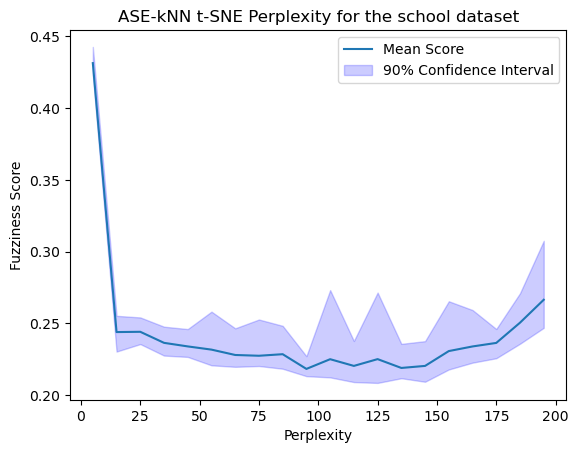

In [239]:
import matplotlib.pyplot as plt

# Assuming the following variables are already computed:
# - perp_values2: x-axis values (e.g., perplexity values)
# - mean_score_values: y-axis values (mean scores)
# - confidence_intervals: 2D array where the first row is lower bounds and the second row is upper bounds

# Step 1: Extract the lower and upper bounds
lower_bounds = confidence_intervals[0, :]
upper_bounds = confidence_intervals[1, :]

# Step 2: Plot the mean score values
plt.plot(perp_values2, mean_score_values2, label='Mean Score')
#plt.plot([10,10],[2300,2600])

# Step 3: Fill the area between the lower and upper bounds to represent confidence intervals
plt.fill_between(perp_values2, lower_bounds, upper_bounds, color='b', alpha=0.2, label='90% Confidence Interval')

# Step 4: Add labels, title, and save the figure
plt.xlabel(f"Perplexity")
plt.ylabel(f"Fuzziness Score")
plt.title(f"ASE-kNN t-SNE Perplexity for the school dataset")
plt.legend()

# Save the figure with confidence intervals
plt.savefig("figs/MeanPerplexity_vs_Score_with_CI_schoolA1_B50.png", facecolor='w')
plt.show()

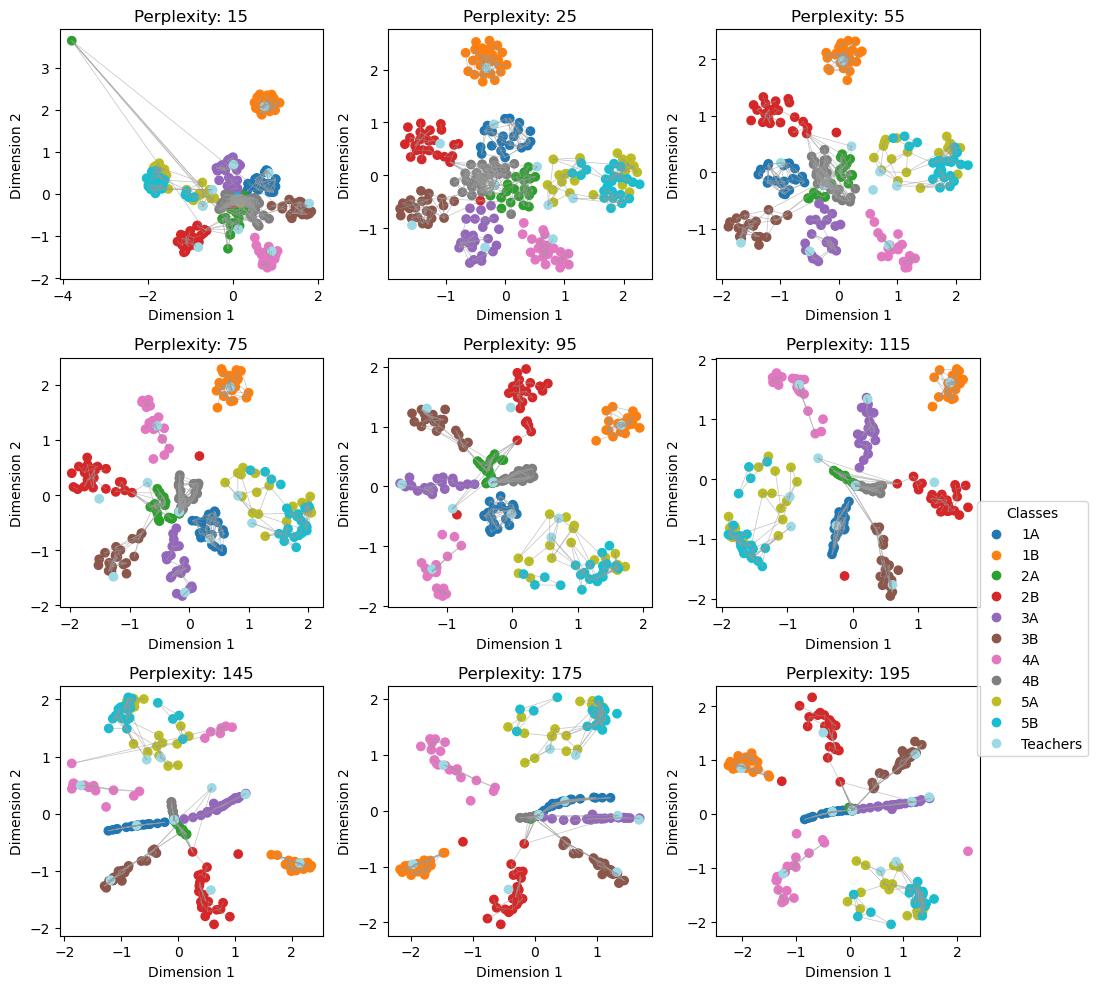

In [42]:
# Define the list of perplexity values

perps=[15,25,55,
       75,95,115,
       145,175,195]
perp_idx=[perp_values.index(x) for x in perps]
A_array3x3=[tsne_list[x] for x in perp_idx]

# Set up the 2m2subplot grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
# Iterate over the embeddings and subplot indices
for idx, A_tsne in enumerate(A_array3x3):

    # Convert to DataFrame
    A_tsne_df = pd.DataFrame(A_tsne)
    A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
    A_tsne_df["tau"] = np.tile(node_labels, 1)

    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension_1"], A_tsne_df["Dimension_2"], c=A_tsne_df["tau"], cmap='tab20',zorder=0)
    ax.set_title(f"Perplexity: {perps[idx]}")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the "friends" matrix, U
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if in_cov_friends_symm_knn[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension_1"].iloc[i], A_tsne_df["Dimension_1"].iloc[j]], 
                        [A_tsne_df["Dimension_2"].iloc[i], A_tsne_df["Dimension_2"].iloc[j]], 
                        '-', lw=0.5, color='#99999999',zorder=1)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.savefig("figs/schoolA0_tsne_perplexity_appendix.png", facecolor='white')

# Show the combined plot
plt.show()

### Get characteristic embeddings

In [43]:
visperp=[15,45]
idx=perp_values2.index(visperp[0])
perp_val=perp_values2[idx]

In [44]:
run=np.argmin(scores_array2[:,idx])
# Create the t-SNE embedding
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=run)
        # tSNE the true adjacency matrix
A_tsne = tsne.fit_transform(dense_adj)

        # Convert to DataFrame
A_tsne_df = pd.DataFrame(A_tsne)
A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
A_tsne_df["tau"] = np.tile(node_labels, 1)

        # Standardize the data in the Dimension_1 and Dimension_2 columns - mean 0, sd 1
scaler = StandardScaler()
        # Fit the scaler on the Dimension columns and transform them
A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])

print(uncertainty_score(A_tsne_df.iloc[:, 0:2].values,dense_adj))

A_tsne_df_plow_best=A_tsne_df

NameError: name 'scores_array2' is not defined

In [244]:
run=np.argmax(scores_array2[:,idx])
# Create the t-SNE embedding
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=run)
        # tSNE the true adjacency matrix
A_tsne = tsne.fit_transform(dense_adj)

        # Convert to DataFrame
A_tsne_df = pd.DataFrame(A_tsne)
A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
A_tsne_df["tau"] = np.tile(node_labels, 1)

        # Standardize the data in the Dimension_1 and Dimension_2 columns - mean 0, sd 1
scaler = StandardScaler()
        # Fit the scaler on the Dimension columns and transform them
A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])

print(uncertainty_score(A_tsne_df.iloc[:, 0:2].values,dense_adj))

A_tsne_df_plow_worst=A_tsne_df

0.4760953503223444


In [245]:
idx=perp_values2.index(visperp[1])
perp_val=perp_values2[idx]

In [246]:
run=np.argmin(scores_array2[:,idx])
# Create the t-SNE embedding
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=run)
        # tSNE the true adjacency matrix
A_tsne = tsne.fit_transform(dense_adj)

        # Convert to DataFrame
A_tsne_df = pd.DataFrame(A_tsne)
A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
A_tsne_df["tau"] = np.tile(node_labels, 1)

        # Standardize the data in the Dimension_1 and Dimension_2 columns - mean 0, sd 1
scaler = StandardScaler()
        # Fit the scaler on the Dimension columns and transform them
A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])

print(uncertainty_score(A_tsne_df.iloc[:, 0:2].values,dense_adj))

A_tsne_df_phigh_best=A_tsne_df

0.38109987297769393


In [247]:
run=np.argmax(scores_array2[:,idx])
# Create the t-SNE embedding
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=run)
        # tSNE the true adjacency matrix
A_tsne = tsne.fit_transform(dense_adj)

        # Convert to DataFrame
A_tsne_df = pd.DataFrame(A_tsne)
A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
A_tsne_df["tau"] = np.tile(node_labels, 1)

        # Standardize the data in the Dimension_1 and Dimension_2 columns - mean 0, sd 1
scaler = StandardScaler()
        # Fit the scaler on the Dimension columns and transform them
A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])

print(uncertainty_score(A_tsne_df.iloc[:, 0:2].values,dense_adj))

A_tsne_df_phigh_worst=A_tsne_df

0.3761239088682674


In [248]:
A_array=[A_tsne_df_plow_best,A_tsne_df_plow_worst,
        A_tsne_df_phigh_best,A_tsne_df_phigh_worst]

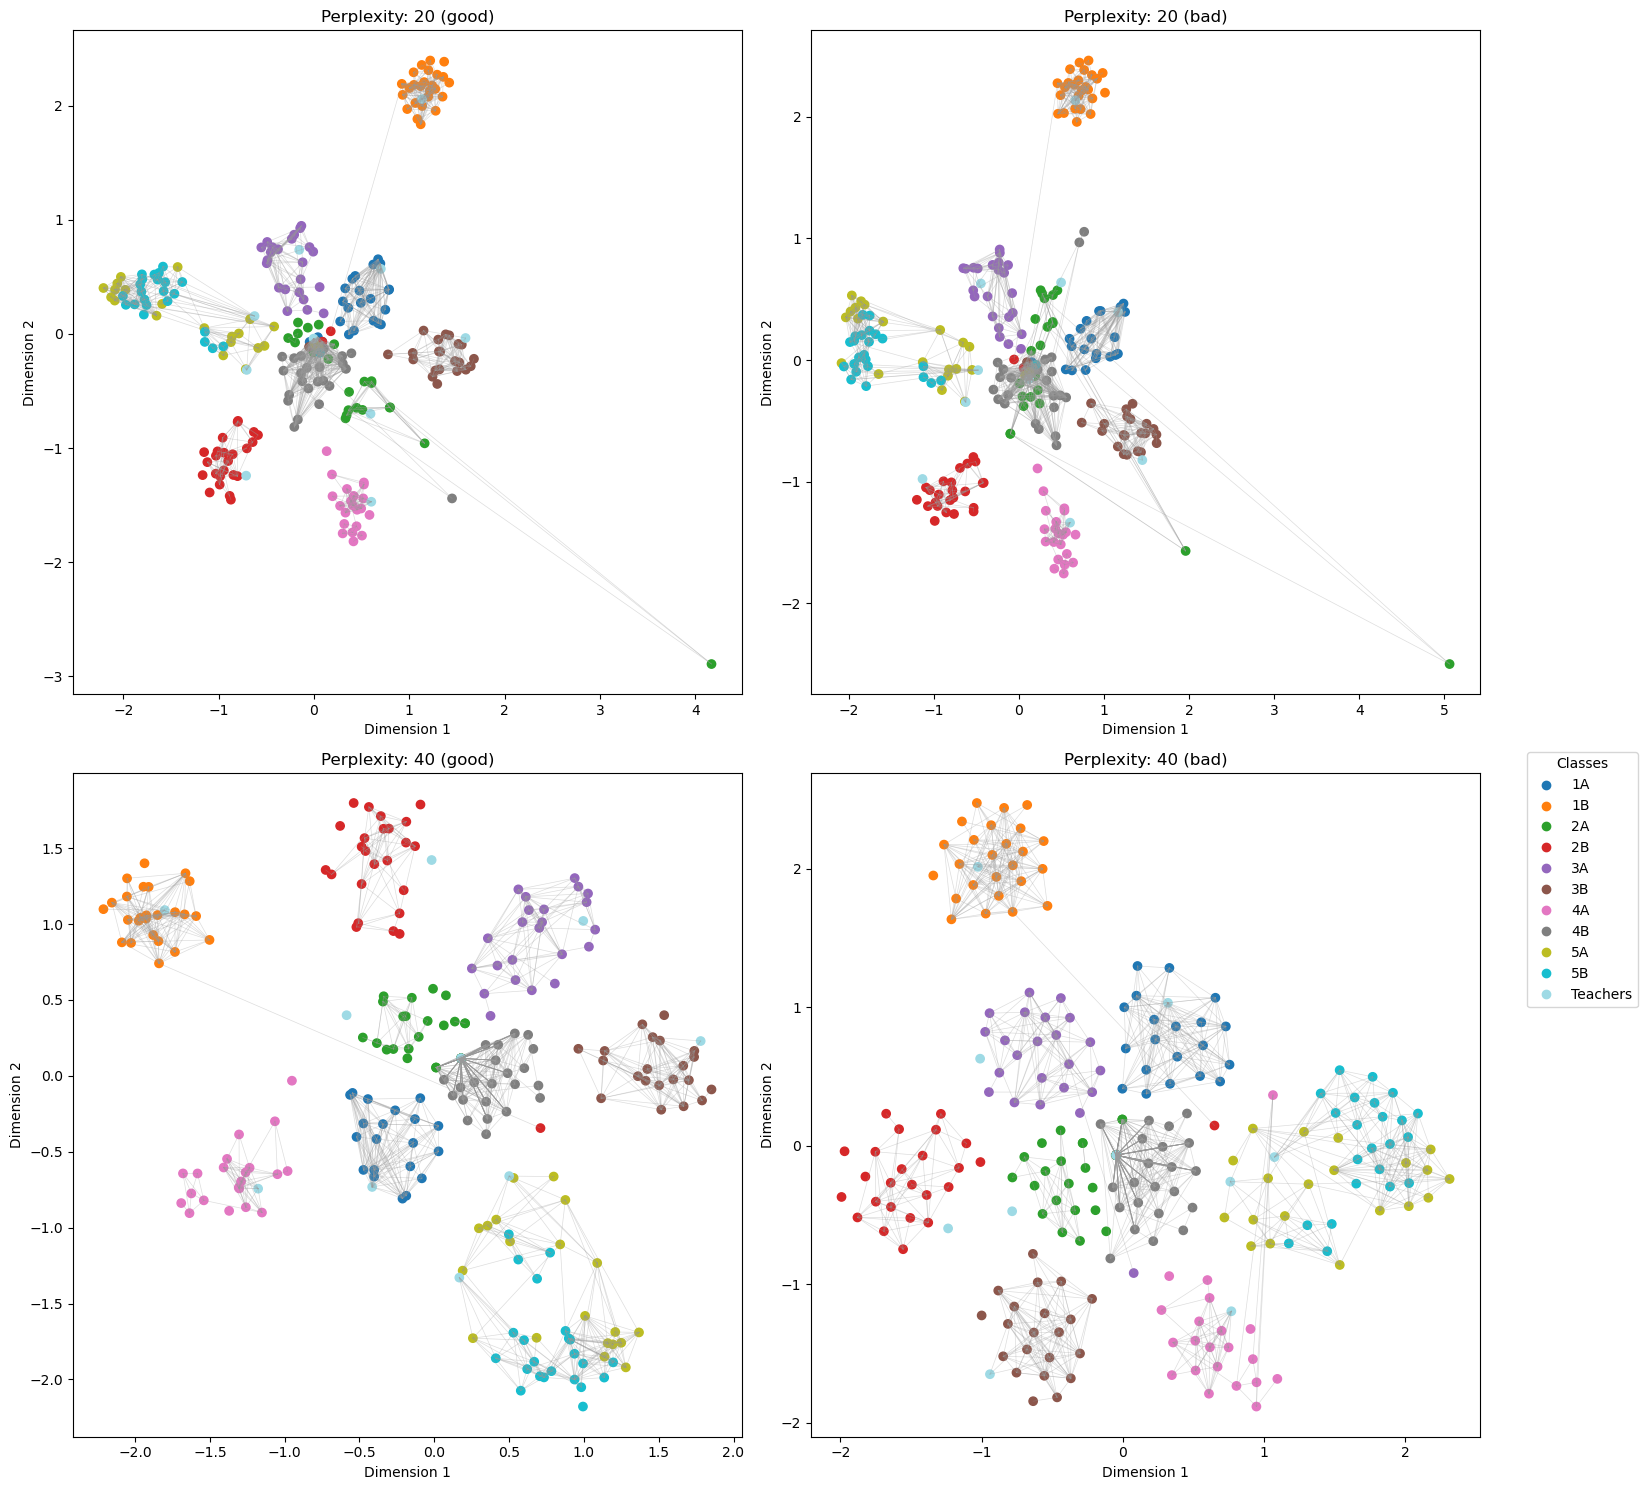

In [249]:
# Define the list of perplexity values

# Set up the 2m2subplot grid
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
perps=[20,20,40,40]
annot=["good","bad","good","bad"]
# Iterate over the embeddings and subplot indices
for idx, A_tsne in enumerate(A_array):

    # Convert to DataFrame
    A_tsne_df = pd.DataFrame(A_tsne)
    A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
    A_tsne_df["tau"] = np.tile(node_labels, 1)

    # Select the subplot
    ax = axs[idx // 2, idx % 2]

    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension_1"], A_tsne_df["Dimension_2"], c=A_tsne_df["tau"], cmap='tab20',zorder=0)
    ax.set_title(f"Perplexity: {perps[idx]} ({annot[idx]})")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the "friends" matrix, U
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension_1"].iloc[i], A_tsne_df["Dimension_1"].iloc[j]], 
                        [A_tsne_df["Dimension_2"].iloc[i], A_tsne_df["Dimension_2"].iloc[j]], 
                        '-', lw=0.5, color='#99999955',zorder=1)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("schoolA0_tsne_perplexity_B20_plot_PCA(A).png", facecolor='white')

# Show the combined plot
plt.show()